<a href="https://colab.research.google.com/github/rakesh4real/one-or-few-shot-learning/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import random, time, pickle
import numpy as np
import matplotlib.pyplot as plt   

import torch
import torch.nn as nn
from torchvision import datasets
from torch.autograd import Variable
from torchvision import transforms

In [37]:
class Dataset(object):
    '''
    Input: numpy values
    Output: torch variables.
    '''
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

In [38]:
def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10): # for MNIST dataset: as we have 10 digits
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1] / 255.) # Image Preprocessing Step
            x1_data.append(data[z2] / 255.) # Image Preprocessing Step
            label.append(1)
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1] / 255.) # Image Preprocessing Step
            x1_data.append(data[z2] / 255.) # Image Preprocessing Step
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32)
    x0_data = x0_data.reshape([-1, 1, 28, 28])
    x1_data = np.array(x1_data, dtype=np.float32)
    x1_data = x1_data.reshape([-1, 1, 28, 28])
    label = np.array(label, dtype=np.int32)
    return x0_data, x1_data, label

In [39]:
def create_iterator(data, label, batchsize, shuffle=False):
    digit_indices = [np.where(label == i)[0] for i in range(10)]
    x0, x1, label = create_pairs(data, digit_indices)
    ret = Dataset(x0, x1, label)
    return ret

In [40]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidean distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

In [41]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 4 * 4, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [43]:
batchsize=128
train = datasets.MNIST(root='../data/',train=True,download=True)
test = datasets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))
indices= np.random.choice(len(train.targets.numpy()), 2000, replace=False)
indices_test= np.random.choice(len(test.targets.numpy()), 100, replace=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [45]:

train_iter = create_iterator(train.data.numpy()[indices],train.targets.numpy()[indices],batchsize)
test_iter = create_iterator(test.data.numpy()[indices_test],test.targets.numpy()[indices_test],batchsize)

# call model
model = SiameseNetwork()
learning_rate = 0.01 # learning rate for optimization
momentum = 0.9 # momentum

# Loss and Optimizer
criterion = contrastive_loss_function # we will use contrastive loss function as defined above
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)

# creating a train loader, and a test loader.
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=True)

In [46]:
train_loss = []
epochs =100
for epoch in range(epochs):
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model(x0, x1)
        loss = criterion(output1, output2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % batchsize == 0:
            print('Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Epoch: 0 	Loss: 0.296349
Epoch: 1 	Loss: 0.158482
Epoch: 2 	Loss: 0.116614
Epoch: 3 	Loss: 0.100043
Epoch: 4 	Loss: 0.081079
Epoch: 5 	Loss: 0.102815
Epoch: 6 	Loss: 0.079971
Epoch: 7 	Loss: 0.081676
Epoch: 8 	Loss: 0.066844
Epoch: 9 	Loss: 0.072002
Epoch: 10 	Loss: 0.055109
Epoch: 11 	Loss: 0.068287
Epoch: 12 	Loss: 0.053456
Epoch: 13 	Loss: 0.051234
Epoch: 14 	Loss: 0.047541
Epoch: 15 	Loss: 0.045960
Epoch: 16 	Loss: 0.043663
Epoch: 17 	Loss: 0.042646
Epoch: 18 	Loss: 0.044977
Epoch: 19 	Loss: 0.039377
Epoch: 20 	Loss: 0.044013
Epoch: 21 	Loss: 0.042212
Epoch: 22 	Loss: 0.033449
Epoch: 23 	Loss: 0.035547
Epoch: 24 	Loss: 0.038158
Epoch: 25 	Loss: 0.036395
Epoch: 26 	Loss: 0.024858
Epoch: 27 	Loss: 0.030776
Epoch: 28 	Loss: 0.020719
Epoch: 29 	Loss: 0.022757
Epoch: 30 	Loss: 0.024776
Epoch: 31 	Loss: 0.027542
Epoch: 32 	Loss: 0.017781
Epoch: 33 	Loss: 0.020484
Epoch: 34 	Loss: 0.020752
Epoch: 35 	Loss: 0.017847
Epoch: 36 	Loss: 0.014452
Epoch: 37 	Loss: 0.021394
Epoch: 38 	Loss: 0.014

In [47]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()

def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999']

        for i in range(10):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        plt.savefig(name)

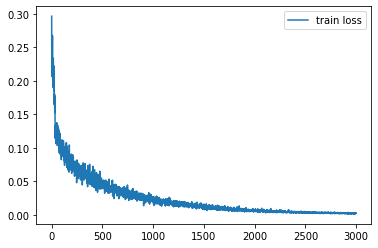

In [48]:
plot_loss(train_loss)

In [49]:
def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for batch_idx, (x, labels) in enumerate(test_loader):
                x, labels = Variable(x), Variable(labels)
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.extend(labels.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        plot_mnist(numpy_all, numpy_labels)

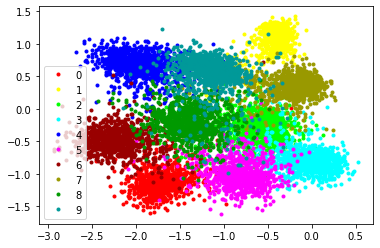

In [50]:
testing_plots(model)